<img style="float: left;" src="images/unige_csd.png" alt="drawing" width="200"/>

# <center>Imagerie Numérique 2023 Automne</center>

<center>December 8, 2023</center>

# <center><ins>TP Class N°6 - Spatial filters</ins></center>

 #### *Instructions :*  

* This TP should be completed and uploaded on Moodle before **Thursday 21 December 2023, 23h59**.
* The name of the file you upload should be **TP6_name_surname.ipynb**.
* If you need to include attached files to you TP, please archive them together in a folder named **TP6_name_surname.zip**.

Preamble code with imports and helper functions:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import uint8 as u8, pi, uint32 as u32, uint64 as u64, float64 as f64, float32 as f32
from numpy.typing import NDArray
from PIL import Image
from copy import deepcopy
import skimage as sk
from skimage import util
import skimage.transform as skt

FIG_SIZE = np.asarray((20, 10))
FIG_SIZE_INV = np.asarray((10, 20))


def imread(path: str, dtype: type = f64, grayscale: bool = False) -> NDArray:
    """
    Load the image at given path into a numpy array
    @param path: path to image (relative to this file)
    @param dtype: if float, returned image will be in the [0, 1] range, else in [0, 255] (defaults to uint8)
    @param grayscale: whether to load image as grayscale or not
    @return: NDArray of shape (m, n, 3) if grayscale is False, else (m, n)
    """
    # img: Image = Image.open(path)
    # if grayscale: img = img.convert('L')
    # out = np.array(img)
    out: NDArray = plt.imread(path)
    if grayscale and len(out.shape) >= 3: out = sk.color.rgb2gray(out)
    if dtype is None: return out

    img_max = np.max(out)
    is_img_float = img_max <= 1
    is_given_float = np.issubdtype(dtype, np.floating)
    if not is_given_float and is_img_float:
        out = u8(out * 255)
    elif is_given_float and not is_img_float:
        out = f64(out / 255.)
    return out if out.dtype == dtype else out.astype(dtype)


def imshow_gray(data, show=True, axis=True, title=None):
    plt.imshow(data, cmap="gray")
    plt.axis("on" if axis else "off")
    if title: plt.title(title)
    if show: plt.show()


def imshow(data, show=True, axis=True, title=None):
    plt.imshow(data)
    plt.axis("on" if axis else "off")
    if title: plt.title(title)
    if show: plt.show()


def MSE(im1: NDArray[float], im2: NDArray[float]):
    """Ensure that dtype is float for both images before applying!"""
    # return np.sum((im1 - im2) ** 2) / (im1.shape[0] * im1.shape[1])
    return np.mean((im1 - im2) ** 2)


def psnr(im1: NDArray[float], im2: NDArray[float]):
    """Ensure that dtype is float for both images before applying!"""
    return 10 * np.log(im1.max() / MSE(im1, im2))


def image_plot(idx: int, data, title=None, col=4, row=1, gray=True, vmax=None):
    plt.subplot(row, col, idx + 1)
    plt.title(title if title else "")
    plt.axis("off")
    plt.imshow(data, cmap="gray" if gray else None, vmin=0, vmax=vmax)
    if idx == (col * row): plt.show()


def bar_plot(idx: int, x, height, title=None, axis="off", col=4, row=1, color=None):
    plt.subplot(row, col, idx + 1)
    plt.title(title if title else "")
    plt.axis(axis)
    plt.bar(x, height, color=color)
    if idx == (col * row): plt.show()


def to_anti_trig(angle, rad=False):
    """Transforms an angle in trigonometric sense (counter-clockwise) to anti-trigonometric sense (clockwise). 
    i.e. 2pi - angle"""
    return 360 - angle if not rad else 2 * pi - angle

# Exercise 1. Explain the code <span style="font-size: 16px; font-weight:normal; font-style: italic;"> (0.25 point)</span> <span style="color:red;font-size: 16px; font-weight:normal">

Run the following code. Explain the difference in the produced results. Make conclusion.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot(I, Titles, dr=1, dc=1, cmap="gray"):
    fig = plt.figure(figsize=FIG_SIZE)
    for i in range(len(I)):
      plt.subplot(dr,dc,i+1)
      plt.imshow(I[i], cmap=cmap)
      plt.title(Titles[i])
      plt.axis("off")

    plt.show()

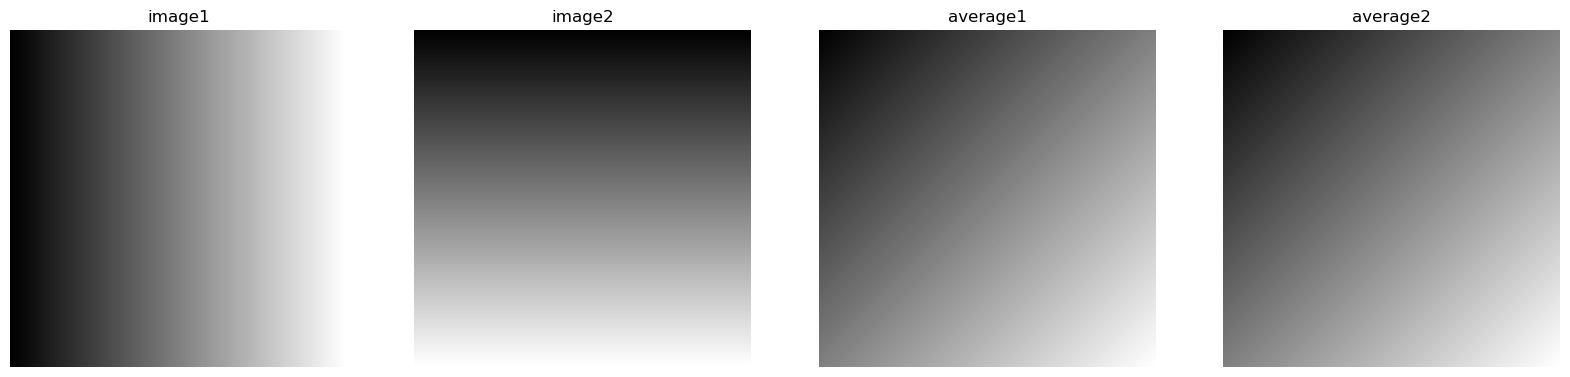

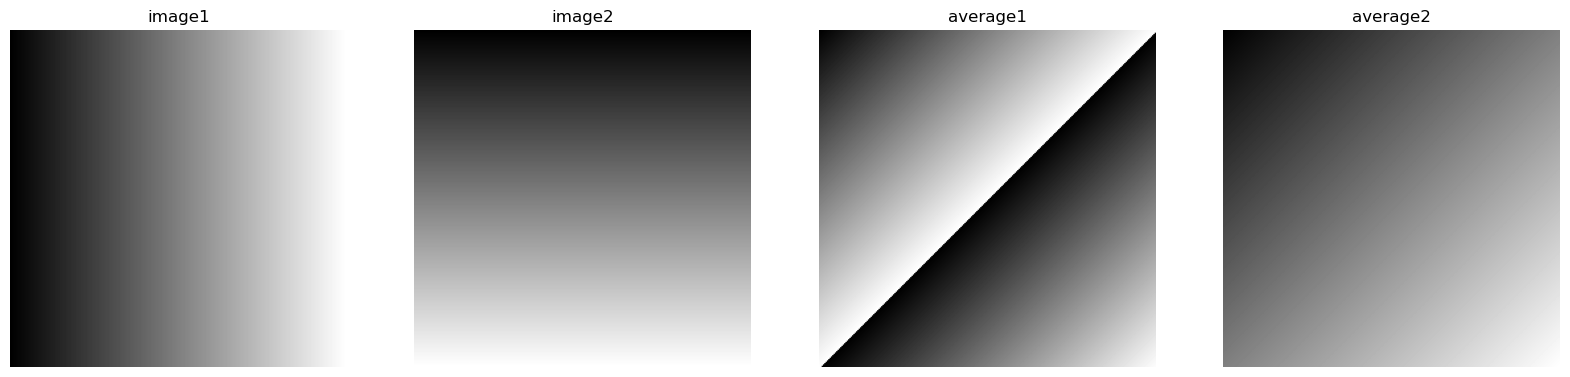

In [3]:
image1 = np.arange(0, 255)*np.ones((255, 255))
image2 = np.transpose(np.copy(image1))
av1 = (image1 + image2)/2
av2 = image1/2 + image2/2

plot([image1, image2, av1, av2], 
     ["image1", "image2", "average1", "average2"], 
     dc=4)

image1 = image1.astype(np.uint8)
image2 = image2.astype(np.uint8)
av1 = (image1 + image2)/2
av2 = image1/2 + image2/2

plot([image1, image2, av1, av2], 
     ["image1", "image2", "average1", "average2"], 
     dc=4)


We, again, have an overflow problem.
By using uint8, we have that both image have values upper bounded by 256.
And by doing img1 + img2, python is going to infer the result type of the addition of 2 uint8 ndarray as being also uint8.

Or it cannot store the result of the addition of 2 uint8 ndarray if each of them has a pixel > 128 (the division by 2 only comes after and does not solve this problem)
which explains the weird image (average 1 at the bottom right corner)

# Exercise 2. Convolution and correlation <span style="font-size: 16px; font-weight:normal; font-style: italic;"> (0.75 point)</span>

Let there be the functions:

>$
\begin{array}{rcl}
x(n) & = & \delta(n-1) + \delta(n-2) + \delta(n-3)\\
h_1(n) & = & \delta(n) + 2\delta(n-1) + 3\delta(n-2) \\
h_2(n) & = & \delta(n+2) + 2\delta(n+1) + 3\delta(n) + 2\delta(n-1) + \delta(n-2)\\
\end{array}
$

(a) Convolve manually $x(n)$ with $h_1(n)$ and $h_2(n)$.

$$
\begin{aligned}
  x(n) * h_1(n) &= \sum_{m = -\infty}^{\infty} x(m) h_1(n - m) \\
  &= \sum_{m = -\infty}^{\infty} (\delta(m-1) + \delta(m-2) + \delta(m-3))(\delta(n-m) + 2\delta(n-m-1) + 3\delta(n-m-2)) \\
  &= \sum_{m = -\infty}^{\infty} \delta(m-1) h_1(n-m) + \sum_{m = -\infty}^{\infty} \delta(m-2) h_1(n-m) + \sum_{m = -\infty}^{\infty} \delta(m-3) h_1(n-m) \\
  &= h_1(n-1) + h_1(n-2) + h_1(n-3) \\
  &= \delta(n-1) + 3\delta(n-2) + 6\delta(n-3) + 5\delta(n-4) + 3\delta(n-5)
\end{aligned}
$$

$$
\begin{aligned}
  x(n) * h_2(n) &= \sum_{m = -\infty}^{\infty} x(m) h_2(n-m) \\
  &= \sum_{m = -\infty}^{\infty} \delta(m-1) h_2(n-m) + \sum_{m = -\infty}^{\infty} \delta(m-2) h_2(n-m) + \sum_{m = -\infty}^{\infty} \delta(m-3) h_2(n-m) \\
  &= h_2(n-1) + h_2(n-2) + h_2(n-3) \\
  &= \delta(n+1) + 3\delta(n) + 6\delta(n-1) + 7\delta(n-2) + 6\delta(n-3) + 3\delta(n-4) + \delta(n-5)
\end{aligned}
$$

(b) Correlate manually $x(n)$ with $h_1(n)$ and $h_2(n)$.

Similarly, by just switching the - and +, (to go from convolution to correlation) we get:

$$
\begin{aligned}
  x(n) \circ h_1(n) &= \sum_{m = -\infty}^{\infty} x(m) h_1(n + m) \\
  &= h_1(n+1) + h_1(n+2) + h_1(n+3) \\
  &= 6\delta(n+1) + 5\delta(n) + 3\delta(n-1) + 3\delta(n+2) + \delta(n+3) \\
\end{aligned}
$$

$$
\begin{aligned}
  x(n) \circ h_2(n) &= \sum_{m = -\infty}^{\infty} x(m) h_2(n+m) \\
  &= h_2(n+1) + h_2(n+2) + h_2(n+3) \\
  &= 6 \delta(n+3) + 7\delta(n+2) + 6\delta(n+1) + 3\delta(n) + \delta(n-1) + \delta(n+5) + 3\delta(n+4)
\end{aligned}
$$

# Exercise 3. Low Pass Filtering <span style="font-size: 16px; font-weight:normal; font-style: italic;"> (1 point)</span>

(a) Program a function that performs image filtering with a square filter of arbitrary size. <br/>
> **Important:** try to program with a min amount of loops. Ideally without any loops.

In [38]:
def im_filter(img: NDArray, kernel: NDArray) -> NDArray:
    """
    Performs image filtering with a square filter of arbitrary size.
    @param img: image to filter
    @param kernel: filter to apply
    @return: filtered image
    """
    windows = util.view_as_windows(img, kernel.shape)
    return np.sum(kernel * windows, axis=(2, 3))

(b)  By using your function, perform  the filtering of zero padded grayscale image *cameraman.jpg* with an average/box filter: <br/>
> $ h = \frac{1}{9} \left( \begin{array}
  11 & 1 & 1 \\
  1 & 1 & 1 \\
  1 & 1 & 1 \\
  \end{array} \right )$
  
  **Hint:** for zero padding the corresponding *numpy* function could be used.

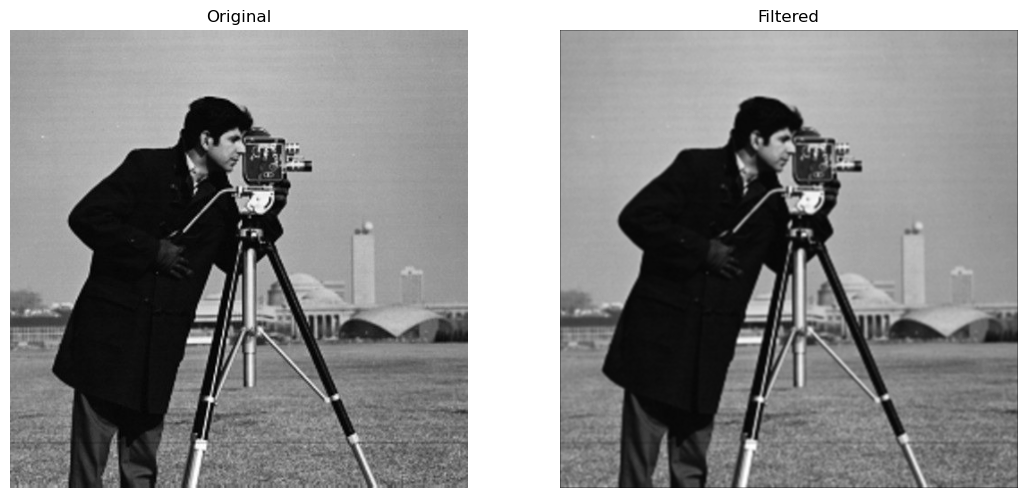

In [39]:
orig = imread('images/cameraman.jpg', dtype=u8, grayscale=True)
h = 1/9 * np.ones((3, 3))

cam = np.pad(orig, (1, 1))
filtered = im_filter(cam, h)

plt.figure(figsize=FIG_SIZE//1.5)
for i in range(2): image_plot(i, [orig, filtered][i], ["Original", "Filtered"][i], col = 2)


(c) By using your function, perform  the filtering of zero padded grayscale image *cameraman.jpg* with a Gaussian filter: <br/>
> $
\begin{align*}
\textbf{h} = \frac{1}{16} \left ( \begin{array}{ccc} 
	1 & 2 & 1 \\
	2 & 4 & 2 \\
	1 & 2 & 1
\end{array}
\right )
\end{align*}
$

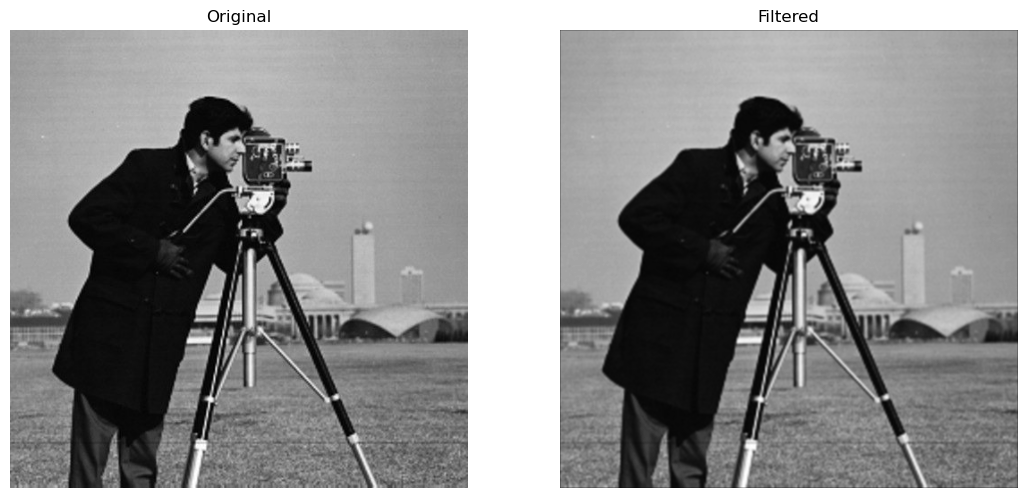

In [42]:
h = 1 / 16 * np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
filtered= im_filter(cam, h)

plt.figure(figsize=FIG_SIZE//1.5)
for i in range(2): image_plot(i, [orig, filtered][i], ["Original", "Filtered"][i], col=2)

(d) How could the average/box and Gaussian filters to be modified to increase the blurring effect, i.e. remove more high frequency components? 

# Exercise 4. Border effects <span style="font-size: 16px; font-weight:normal; font-style: italic;"> (1 point)</span>

Generate an image (as illistrated in Figure 1) of size 512 $\times$ 512. 
<table>
    <tr style="background-color:#FFFFFF;">
    <td style='text-align:center;'>
       <img src='images/002.png' width="200" height="200"/>
    </td>
    </tr>
    <tr>
    <td style='text-align:center;'> 
    Figure 1.
    </td>
    </tr>
</table>

Using the *numpy* padding function and the box filter of size 31 $\times$ 31 (use your implementation from the exercise 1): 

(a) investigate the influence of tree types border padding: 
   * zero padding
   * periodic extension
   * symmetric flip or mirror reflection   

(b) Visualize the original, padded and filtered images. Explain the effects that one can observe.

(c) What are the advantages and disadvantages of each type of border extension?

# Exercise 5. The Laplacian filter <span style="font-size: 16px; font-weight:normal; font-style: italic;"> (1 point)</span> 

The Laplacian filter kernel:
> $
\begin{equation}
\nabla^2 f(x,y) = f(x-1, y) + f(x+1, y) + f(x, y-1) + f(x, y+1) - 4f(x,y) \;\;\;\;\; (1)
\end{equation}
$

(a) Program and test (apply to the grayscale image *cameraman) the Laplacian filter based on the equation (1) and 3 $\times$ 3 neighbourhood. <br/>
> **Hint:** you can represent the equation (1) in a matrix form and use your implementaion  from the exercise 1.

(b) Visualise the original and filtered images. Comment the effect of filtering.

# Exercise 6. Mechanism of sharpening <span style="font-size: 16px; font-weight:normal; font-style: italic;"> (1 point)</span>

Take the grayscale image *cameraman* $A$. Blur this image with a box filter of size 3 $\times$ 3 $B$.

(a) $E_1$: definding the optimal parameters perform the sharpening of $B$ using the Gaussian filter.

(b) $E_2$: definding the optimal parameters perform the sharpening of $B$ using the Laplacian filter. <br/>
>**Hint:** try to find the parameters that minimise the *mse* between the original $A$ and enhanced images $E_1$ and $E_2$.

(c) Display blurred $B$ and enhanced images $E_1$ and $E_2$. Comment the quality of the enhanced images based on the visual quality and based on the *mse* between the original $A$ and enhanced images $E_1$ and $E_2$. <br/>
>**Hint:** for this exercise use the formulas from the Theme 6 page 56.

# Exercise 7. Order statistics filtering <span style="font-size: 16px; font-weight:normal; font-style: italic;"> (1 point)</span>

You are given two noisy images *tp6_005* and *tp6_006* corrupted by "impulse" noise.
<table>
    <tr style="background-color:#FFFFFF;">
    <td style='text-align:center;'>
       <img src='images/tp6_005.jpg' width="250" />
    </td>
    <td style='text-align:center;'>
       <img src='images/tp6_006.jpg' width="200" />
    </td>    
    </tr>
    <tr style="background-color:#FFFFFF;">
    <td style="text-align:center;">(a) tp6_005</td>
    <td style="text-align:center;">(b) tp6_006</td>    
    </tr>
    <tr style="background-color:#FFFFFF;">
    <td colspan=2 style="text-align:center;"> 
    Figure 2.
    </td>
    </tr>    
</table>

(a) Defining the optimal parameters (filter size) by yourself try to remove the noise with: 
   * averaging filter
   * median filter

(b)  Visualise the images before and after filtering. Report the used parameres of filtering. Comment the denoising efficiency based on the visual image quality.   

# Exercise 8. Solving a Jigsaw Puzzle <span style="font-size: 16px; font-weight:normal; font-style: italic;"> (1 point)</span> <span style="color:red;font-size: 16px; font-weight:normal"> Non obligatory, bonus exercise</span> 


The goal of this exercise is to use image processing to automatically solve a jigsaw puzzle. The image *tp6_003* (see Figure 3.a) shows the pieces of a jigsaw puzzle. The reference image *tp6_004* is shown in Figure 3.b. Note that when the puzzle pieces are assembled together, the completed puzzle has potentially a different area than the reference image.
<table>
    <tr style="background-color:#FFFFFF;">
    <td style='text-align:center;'>
       <img src='images/tp6_003.png' width="450" />
    </td>
    <td style='text-align:center;'>
       <img src='images/tp6_004.jpg' width="150" />
    </td>    
    </tr>
    <tr style="background-color:#FFFFFF;">
    <td style="text-align:center;">(a) Puzzle image tp6_003</td>
    <td style="text-align:center;">(b) Reference tp6_004</td>    
    </tr>
    <tr style="background-color:#FFFFFF;">
    <td colspan=2 style="text-align:center;"> 
    Figure 3.
    </td>
    </tr>    
</table>

Implement an image processing algorithm to automatically locate where each jigsaw piece fits in completed puzzle. Clearly describe the steps of your algorithm, showing intermediate results for clarification if helpful. 

> **Hint:** for the cross-correlation you might use *scipy.signal.correlate2d(.)*. 
>
> **Important:** for cross-correlation both images should be normalized (zero mean, unit variance).